In [62]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor 

# Loading dataset

In [63]:
dataset= pd.read_csv('./data/vehicles.csv')

# Data Cleaning

In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

I want to drop the nonrelated columns for now, any time we need them we can add them again to our data frame :)
nonrelated colums  = url , regio, region_url, VIN, image_url, county, state, lat, long, description
i cosider the describtion as nonrelated, because it is a long procces to exctract the information from it, but i will use it as a feature later and i use it for recalculate missed values too.
* i consider the description as non related, because it is a long process to extract the information from it, but i will use it as a feature later and i use it for recalculate missed values too.

In [65]:
non_related_columns = ['id', 'url' , 'region', 'region_url', 'VIN', 'image_url', 'county', 'state', 'lat', 'long', 'description']
data = dataset.drop(columns= non_related_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  posting_date  426812 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 48.9+ MB


## Data quality
### Missing values

In [66]:
#check missing values for the whole dataframe
data.isna().sum().sum()

1054178

In [67]:
# check missing values column
data.isna().sum()

price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
posting_date        68
dtype: int64

i want to find the impact of condition, year and odometer on the price, if they have big effect i must to drop them, because they are not recoveriable.


In [68]:
data['condition'].unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [69]:
#temprary drop tha non value in condition
temp = data.copy()
temp = temp.dropna(subset=['condition'])

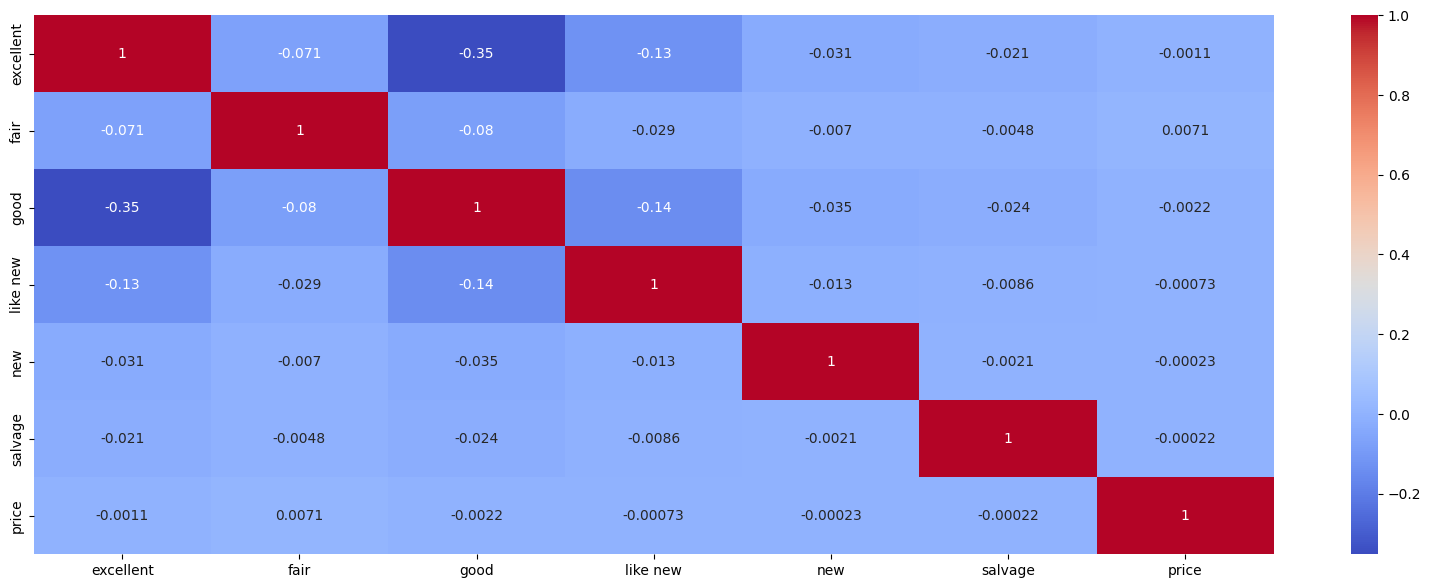

In [70]:
#calculate correlation matris with onehot encoder
corr_matrix = pd.get_dummies(data["condition"]).assign(price = data.price).corr()

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'size':10}, )
plt.show()

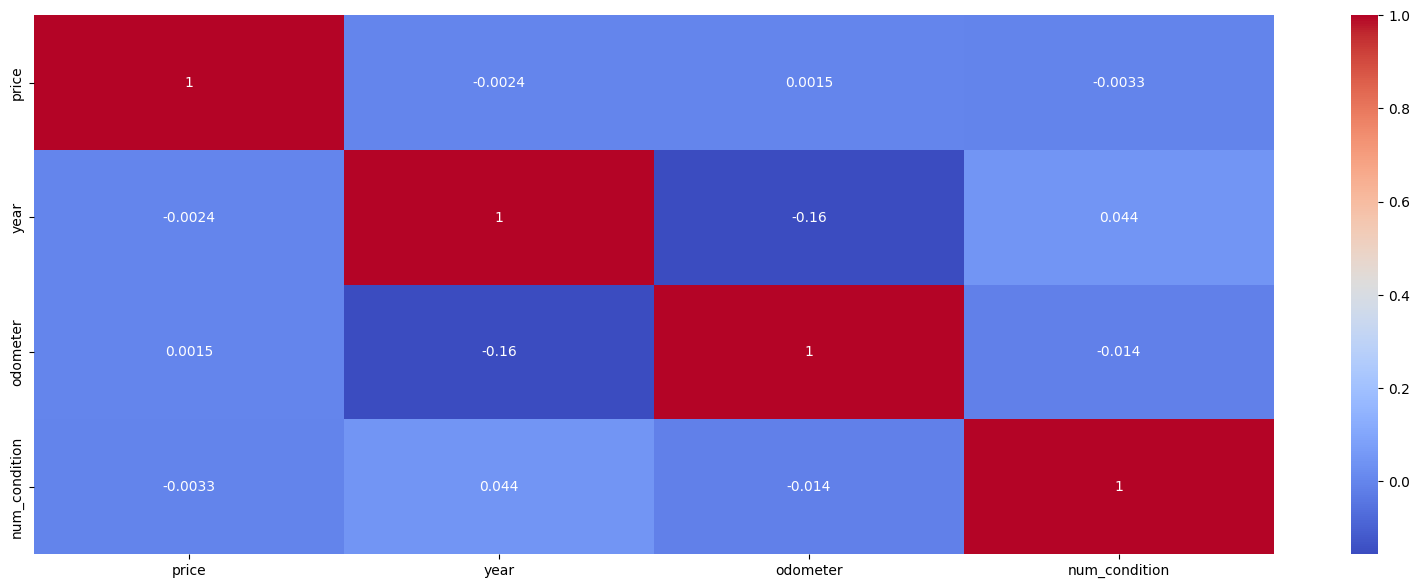

In [71]:
#make ordinar list for condition
con_category= ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
#make a columntransformer
ct= ColumnTransformer([("ordinal", OrdinalEncoder(categories=[con_category]),['condition'])])
# add new column num_condition using the our tranformer
temp['num_condition'] = [x[0] for x in ct.fit_transform(temp)]

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(temp.corr(), cmap='coolwarm', annot=True, annot_kws={'size':10}, )
plt.show()

ok, for now i drop all row with nan values in condition, year and odometer.
* but for cheking the result beter maybe i will try to fill them using the describtion
* for checking the result with ful data and this data i will fill them by easy decissin like mean or mod or something else

In [72]:
data_v1 = data.dropna(subset =['condition', 'year', 'odometer'])
data_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250851 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         250851 non-null  int64  
 1   year          250851 non-null  float64
 2   manufacturer  240069 non-null  object 
 3   model         248581 non-null  object 
 4   condition     250851 non-null  object 
 5   cylinders     180274 non-null  object 
 6   fuel          250835 non-null  object 
 7   odometer      250851 non-null  float64
 8   title_status  245368 non-null  object 
 9   transmission  250817 non-null  object 
 10  drive         190003 non-null  object 
 11  size          96352 non-null   object 
 12  type          218331 non-null  object 
 13  paint_color   199763 non-null  object 
 14  posting_date  250851 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 30.6+ MB


i try to find the data for each manufaturer, if there is small part for any brand i will drop them too.

In [73]:
data_v1['manufacturer'].value_counts()

ford               37563
chevrolet          32208
toyota             20460
honda              12835
nissan             11015
jeep               10442
gmc                 9390
bmw                 9155
ram                 8144
dodge               7590
mercedes-benz       6560
volkswagen          6232
hyundai             5997
subaru              5542
lexus               5280
audi                5217
kia                 4912
cadillac            4489
acura               4477
chrysler            3653
buick               3640
mazda               3591
infiniti            3552
lincoln             3049
volvo               2475
mitsubishi          2327
mini                1598
jaguar              1568
pontiac             1484
rover               1181
mercury              839
alfa-romeo           747
porsche              733
saturn               700
tesla                668
fiat                 566
harley-davidson       84
datsun                41
ferrari               41
aston-martin          12


In [74]:
drop_manufacturer = ['tesla', 'fiat','harley-davidson', 'ferrari', 'datson', 'aston-martin', 'land rover', 'morgan', 'datsun']

In [75]:
data_v2 = data_v1[~data_v1['manufacturer'].isin(drop_manufacturer)]

In [76]:
data_v2['manufacturer'].value_counts()

ford             37563
chevrolet        32208
toyota           20460
honda            12835
nissan           11015
jeep             10442
gmc               9390
bmw               9155
ram               8144
dodge             7590
mercedes-benz     6560
volkswagen        6232
hyundai           5997
subaru            5542
lexus             5280
audi              5217
kia               4912
cadillac          4489
acura             4477
chrysler          3653
buick             3640
mazda             3591
infiniti          3552
lincoln           3049
volvo             2475
mitsubishi        2327
mini              1598
jaguar            1568
pontiac           1484
rover             1181
mercury            839
alfa-romeo         747
porsche            733
saturn             700
Name: manufacturer, dtype: int64

In [77]:
data_v2.isna().sum()

price                0
year                 0
manufacturer     10782
model             2253
condition            0
cylinders        69611
fuel                16
odometer             0
title_status      5462
transmission        34
drive            60567
size            153376
type             32377
paint_color      50733
posting_date         0
dtype: int64

i start to fill mising values from cylenders, i will serach for the same manufactores and model for that row, and if i find that i fill the missed value

In [78]:
def find_number_of_cylinedrs(manufacturer, model):
    result = data_v2.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['cylinders'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['cylinders']

In [79]:


data_v3=(
    data_v2
        .assign(re_cylinders = np.where(
            data_v2['cylinders'].isna(),
            find_number_of_cylinedrs(data_v2['manufacturer'],data_v2['model']),
            data_v2['cylinders']
        ))
)

In [80]:
data_v3.isna().sum()

price                0
year                 0
manufacturer     10782
model             2253
condition            0
cylinders        69611
fuel                16
odometer             0
title_status      5462
transmission        34
drive            60567
size            153376
type             32377
paint_color      50733
posting_date         0
re_cylinders         0
dtype: int64

lts do the same process for fuel, transmission, drive, size, type 

In [81]:
def find_fuel(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['fuel'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['fuel']


def find_transmission(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['transmission'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['transmission']


def find_drive(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['drive'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['drive']

def find_size(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['size'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['size']

def find_type(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['type'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['type']

In [82]:
data_v4=(
    data_v3
        .assign(re_fuel = np.where(
            data_v3['fuel'].isna(),
            find_fuel(data_v3['manufacturer'],data_v3['model']),
            data_v3['fuel']
        ))
        .assign(re_transmission = np.where(
            data_v3['transmission'].isna(),
            find_transmission(data_v3['manufacturer'],data_v3['model']),
            data_v3['transmission']
        ))
        .assign(re_drive = np.where(
            data_v3['drive'].isna(),
            find_drive(data_v3['manufacturer'],data_v3['model']),
            data_v3['drive']
        ))
        .assign(re_size = np.where(
            data_v3['size'].isna(),
            find_size(data_v3['manufacturer'],data_v3['model']),
            data_v3['size']
        ))
        .assign(re_type = np.where(
            data_v3['type'].isna(),
            find_type(data_v3['manufacturer'],data_v3['model']),
            data_v3['type']
        ))
)

In [83]:
data_v4.isna().sum()

price                   0
year                    0
manufacturer        10782
model                2253
condition               0
cylinders           69611
fuel                   16
odometer                0
title_status         5462
transmission           34
drive               60567
size               153376
type                32377
paint_color         50733
posting_date            0
re_cylinders            0
re_fuel                 0
re_transmission         0
re_drive                0
re_size                 0
re_type                 0
dtype: int64

recalculate the models it hard and i just drop them, but i try to recalulate the manufaturer using the model and other details

In [84]:
def find_manufacturer(model, cylinders, fuel, transmission, type):
    result = data_v4.loc[lambda df_ : ((df_['model'] == model) & (df_['re_cylinders'] == cylinders) &(df_['re_fuel'] == fuel) &
                                       (df_['re_transmission'] == transmission)&(df_['re_type'] == type) &
                                       (~df_['manufacturer'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['manufacturer']

In [85]:
data_v5 =(
    data_v4
        .assign(re_manufacturer = np.where(
            data_v4['manufacturer'].isna(),
            find_manufacturer(data_v4['model'],data_v4['re_cylinders'], data_v4['re_fuel'], data_v4['re_transmission'], data_v4['re_type']),
            data_v4['manufacturer']
        ))
)

In [86]:
data_v5.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'posting_date', 're_cylinders', 're_fuel',
       're_transmission', 're_drive', 're_size', 're_type', 're_manufacturer'],
      dtype='object')

In [87]:
data_v5.dropna(subset= ['model', 'title_status'], inplace=True)
columns= ['price', 'year', 're_manufacturer', 'model', 'condition', 're_cylinders', 're_fuel', 'odometer', 'title_status', 're_transmission', 're_drive', 're_size', 're_type', 'posting_date' ,'paint_color']
data_v6 = data_v5[columns]
data_v6.columns = data_v6.columns.str.replace('re_', '')

In [88]:
data_v6.isna().sum()

price               0
year                0
manufacturer        0
model               0
condition           0
cylinders           0
fuel                0
odometer            0
title_status        0
transmission        0
drive               0
size                0
type                0
posting_date        0
paint_color     44602
dtype: int64

In [89]:
data_v6.shape

(241719, 15)

i fill the missed values for paint color by none.

In [90]:
data_v6['paint_color'].fillna(value='none', inplace=True)

C:\Users\sherw\AppData\Local\Temp\ipykernel_10216\3501033760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['paint_color'].fillna(value='none', inplace=True)


In [91]:
data_v6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241719 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   condition     241719 non-null  object 
 5   cylinders     241719 non-null  object 
 6   fuel          241719 non-null  object 
 7   odometer      241719 non-null  float64
 8   title_status  241719 non-null  object 
 9   transmission  241719 non-null  object 
 10  drive         241719 non-null  object 
 11  size          241719 non-null  object 
 12  type          241719 non-null  object 
 13  posting_date  241719 non-null  object 
 14  paint_color   241719 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 29.5+ MB


### Delaing with types an labelize

In [92]:
data_v6['posting_date']

27        2021-05-04T12:31:18-0500
28        2021-05-04T12:31:08-0500
29        2021-05-04T12:31:25-0500
30        2021-05-04T10:41:31-0500
31        2021-05-03T14:02:03-0500
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 241719, dtype: object

i convert posting_date column to datetime format


In [93]:
data_v6['posting_date']= pd.to_datetime(data_v6['posting_date'] , utc=True)

C:\Users\sherw\AppData\Local\Temp\ipykernel_10216\4100576747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['posting_date']= pd.to_datetime(data_v6['posting_date'] , utc=True)


and then i convert it to integer, because i want to this column for my model.

In [94]:
data_v6['posting_date'] = data_v6['posting_date'].dt.year*10000 + data_v6['posting_date'].dt.month*100 + data_v6['posting_date'].dt.day


C:\Users\sherw\AppData\Local\Temp\ipykernel_10216\4181322438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['posting_date'] = data_v6['posting_date'].dt.year*10000 + data_v6['posting_date'].dt.month*100 + data_v6['posting_date'].dt.day


In [95]:
data_v6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241719 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   condition     241719 non-null  object 
 5   cylinders     241719 non-null  object 
 6   fuel          241719 non-null  object 
 7   odometer      241719 non-null  float64
 8   title_status  241719 non-null  object 
 9   transmission  241719 non-null  object 
 10  drive         241719 non-null  object 
 11  size          241719 non-null  object 
 12  type          241719 non-null  object 
 13  posting_date  241719 non-null  int64  
 14  paint_color   241719 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 29.5+ MB


Convert Cylinders
the cylinders have some text in the that we dont need them, at the first step we scrab the digit part of them, and then we convert them to int.


In [96]:
def other_to_0(input):
    if input == 'other': 
        return '0 cylinders'
    return input

In [97]:
data_v6['cylinders'] = data_v6['cylinders'].apply(other_to_0)

C:\Users\sherw\AppData\Local\Temp\ipykernel_10216\2967395791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['cylinders'] = data_v6['cylinders'].apply(other_to_0)


In [98]:
data_v6['cylinders'] = data_v6['cylinders'].str.replace(r'(\d{1,2})(\s)(.*)$', r'\1', regex=True).astype('int64')

C:\Users\sherw\AppData\Local\Temp\ipykernel_10216\1092821188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['cylinders'] = data_v6['cylinders'].str.replace(r'(\d{1,2})(\s)(.*)$', r'\1', regex=True).astype('int64')


its time to convert the the category columns and train the encoders.


In [99]:
data_v6['condition'].unique()

array(['good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [100]:
data_v6['fuel'].unique()

array(['gas', 'other', 'diesel', 'hybrid', 'electric'], dtype=object)

In [101]:
data_v6['title_status'].unique()

array(['clean', 'rebuilt', 'lien', 'salvage', 'missing', 'parts only'],
      dtype=object)

In [102]:
data_v6['transmission'].unique()

array(['other', 'automatic', 'manual'], dtype=object)

In [103]:
data_v6['drive'].unique()

array(['rwd', '4wd', 'fwd'], dtype=object)

In [104]:
data_v6['size'].unique()

array(['full-size', 'mid-size', 'compact', 'sub-compact'], dtype=object)

In [105]:
data_v6['paint_color'].unique()

array(['white', 'blue', 'red', 'black', 'silver', 'grey', 'none', 'brown',
       'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object)

In [106]:
data_v6.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'posting_date', 'paint_color'],
      dtype='object')

In [107]:
#ordinal encoder list
ordinal_columns= ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'paint_color']


ord_condition_list = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
ord_fuel_list = ['other', 'diesel', 'gas', 'hybrid', 'electric']
ord_title_status_list = ['salvage', 'missing', 'parts only', 'rebuilt', 'lien', 'clean']
ord_tranmission_list = ['other', 'manual', 'automatic']
ord_drive_list= ['fwd', 'rwd', '4wd']
ord_size_list = ['mid-size','full-size', 'sub-compact', 'compact']
ord_paint_color = ['white', 'blue', 'red', 'black', 'silver', 'grey', 'none', 'brown',
                   'yellow', 'orange', 'green', 'custom', 'purple']
ordinal_lists = [ord_condition_list,ord_fuel_list,ord_title_status_list,ord_tranmission_list,ord_drive_list,ord_size_list,ord_paint_color]
# i use onehot encoder for the others 

In [108]:
ct_ordinal= ColumnTransformer([("ordinal", OrdinalEncoder(categories=ordinal_lists),ordinal_columns)])
ct_ordinal.fit(data_v6)

ColumnTransformer(transformers=[('ordinal',
                                 OrdinalEncoder(categories=[['salvage', 'fair',
                                                             'good',
                                                             'excellent',
                                                             'like new',
                                                             'new'],
                                                            ['other', 'diesel',
                                                             'gas', 'hybrid',
                                                             'electric'],
                                                            ['salvage',
                                                             'missing',
                                                             'parts only',
                                                             'rebuilt', 'lien',
                                                             'clean'],
                                                            ['other', 'manual',
                                                             'automatic'],
                                                            ['fwd', 'rwd',
                                                             '4wd'],
                                                            ['mid-size',
                                                             'full-size',
                                                             'sub-compact',
                                                             'compact'],
                                                            ['white', 'blue',
                                                             'red', 'black',
                                                             'silver', 'grey',
                                                             'none', 'brown',
                                                             'yellow', 'orange',
                                                             'green', 'custom',
                                                             'purple']]),
                                 ['condition', 'fuel', 'title_status',
                                  'transmission', 'drive', 'size',
                                  'paint_color'])])

In [109]:
ordinal_df = pd.DataFrame(ct_ordinal.transform(data_v6), columns= ordinal_columns)

data_v7 = data_v6.copy()
data_v7.reset_index(inplace=True, drop=True)
data_v7.drop(columns=ordinal_columns, inplace= True) 
data_v7[ordinal_columns]= ordinal_df[ordinal_columns]
# data_v7=pd.concat([data_v7, ordinal_df], axis=1, join="inner")
data_v7.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241719 entries, 0 to 241718
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   cylinders     241719 non-null  int64  
 5   odometer      241719 non-null  float64
 6   type          241719 non-null  object 
 7   posting_date  241719 non-null  int64  
 8   condition     241719 non-null  float64
 9   fuel          241719 non-null  float64
 10  title_status  241719 non-null  float64
 11  transmission  241719 non-null  float64
 12  drive         241719 non-null  float64
 13  size          241719 non-null  float64
 14  paint_color   241719 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 27.7+ MB


In [110]:
data_v7.describe()

,price,year,cylinders,odometer,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
count,2.417190e+05,241719.000000,241719.000000,2.417190e+05,2.417190e+05,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000
mean,6.151027e+04,2010.733703,6.570108,9.732563e+04,2.021044e+07,2.541662,1.788767,4.892644,1.462504,1.020578,0.993128,3.343192
std,1.128491e+07,9.831953,1.643879,2.146261e+05,3.763783e+01,0.720952,0.621617,0.605503,0.850551,0.765271,0.569998,2.663288
min,0.000000e+00,1900.000000,0.000000,0.000000e+00,2.021040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.500000e+03,2008.000000,6.000000,3.394600e+04,2.021042e+07,2.000000,2.000000,5.000000,1.000000,0.000000,1.000000,1.000000
50%,1.450000e+04,2013.000000,8.000000,8.339400e+04,2.021043e+07,2.000000,2.000000,5.000000,2.000000,1.000000,1.000000,3.000000
75%,2.699000e+04,2017.000000,8.000000,1.350435e+05,2.021050e+07,3.000000,2.000000,5.000000,2.000000,2.000000,1.000000,6.000000
max,3.736929e+09,2022.000000,12.000000,1.000000e+07,2.021050e+07,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,12.000000


In [111]:
ordinal_df = pd.DataFrame(ct_ordinal.transform(data_v6), columns= ordinal_columns)

data_v7 = data_v6.copy()
data_v7.reset_index(inplace=True, drop=True)
data_v7.drop(columns=ordinal_columns, inplace= True) 
data_v7[ordinal_columns]= ordinal_df[ordinal_columns]
# data_v7=pd.concat([data_v7, ordinal_df], axis=1, join="inner")
data_v7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241719 entries, 0 to 241718
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   cylinders     241719 non-null  int64  
 5   odometer      241719 non-null  float64
 6   type          241719 non-null  object 
 7   posting_date  241719 non-null  int64  
 8   condition     241719 non-null  float64
 9   fuel          241719 non-null  float64
 10  title_status  241719 non-null  float64
 11  transmission  241719 non-null  float64
 12  drive         241719 non-null  float64
 13  size          241719 non-null  float64
 14  paint_color   241719 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 27.7+ MB


# Outlier

there are many records with nosense prices, then i want to drop the records with price under 1000 and upper thean 100000 


In [ ]:
data_v8 =data_v7[(data_v7['price']> 1000) & (data_v7['price'] < 100000)]
data_v8

In [113]:
from scipy import stats
df_filtered = data_v8.copy()
for column in df_filtered.select_dtypes(include="number").columns:
    q_low = df_filtered[column].quantile(0.2)
    q_hi  = df_filtered[column].quantile(0.8)
    data_v9 = df_filtered[(df_filtered[column] < q_hi) & (df_filtered[column] > q_low)]

In [114]:
data_v9.describe()

,price,year,cylinders,odometer,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
count,122035.000000,122035.000000,122035.000000,1.220350e+05,1.220350e+05,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000
mean,17960.317335,2010.986709,6.420322,9.447312e+04,2.021044e+07,2.517663,1.803696,4.880559,1.429090,0.989978,0.992904,2.969214
std,12936.055171,9.212154,1.657810,1.735817e+05,3.785228e+01,0.701707,0.621409,0.629751,0.867508,0.799913,0.632535,1.252349
min,1057.000000,1900.000000,0.000000,0.000000e+00,2.021040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7194.000000,2008.000000,6.000000,3.442500e+04,2.021042e+07,2.000000,2.000000,5.000000,0.000000,0.000000,1.000000,2.000000
50%,14990.000000,2013.000000,6.000000,8.316000e+04,2.021043e+07,2.000000,2.000000,5.000000,2.000000,1.000000,1.000000,3.000000
75%,26990.000000,2017.000000,8.000000,1.340600e+05,2.021050e+07,3.000000,2.000000,5.000000,2.000000,2.000000,1.000000,4.000000
max,99999.000000,2022.000000,12.000000,1.000000e+07,2.021050e+07,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,5.000000


In [115]:
# data_v7['models_rank']= (
#                     data_v7
#                             .groupby(['manufacturer','model'])
#                             # .agg({'price': 'mean'})
#                             # .sort_values('price')
#                             # .reset_index()
#                             ['model'].rank(method='first')
#                         )

In [116]:
# data_v7.groupby('manufacturer')['model'].nunique()

In [117]:
# data_v7.loc[lambda df_ : df_['manufacturer'] == 'volvo']['models_rank'].max()

In [118]:
# manufacturers =(
#     data_v6
#             .groupby('manufacturer')
#             .agg({'price': 'mean'})
#             .sort_values('price', ascending=True)
#             .reset_index()
            
# )
# manufacturers['manufacturer'].unique()

In [119]:
data_v10 = pd.get_dummies(data_v9)

In [120]:
data_v10.shape

(122035, 12270)

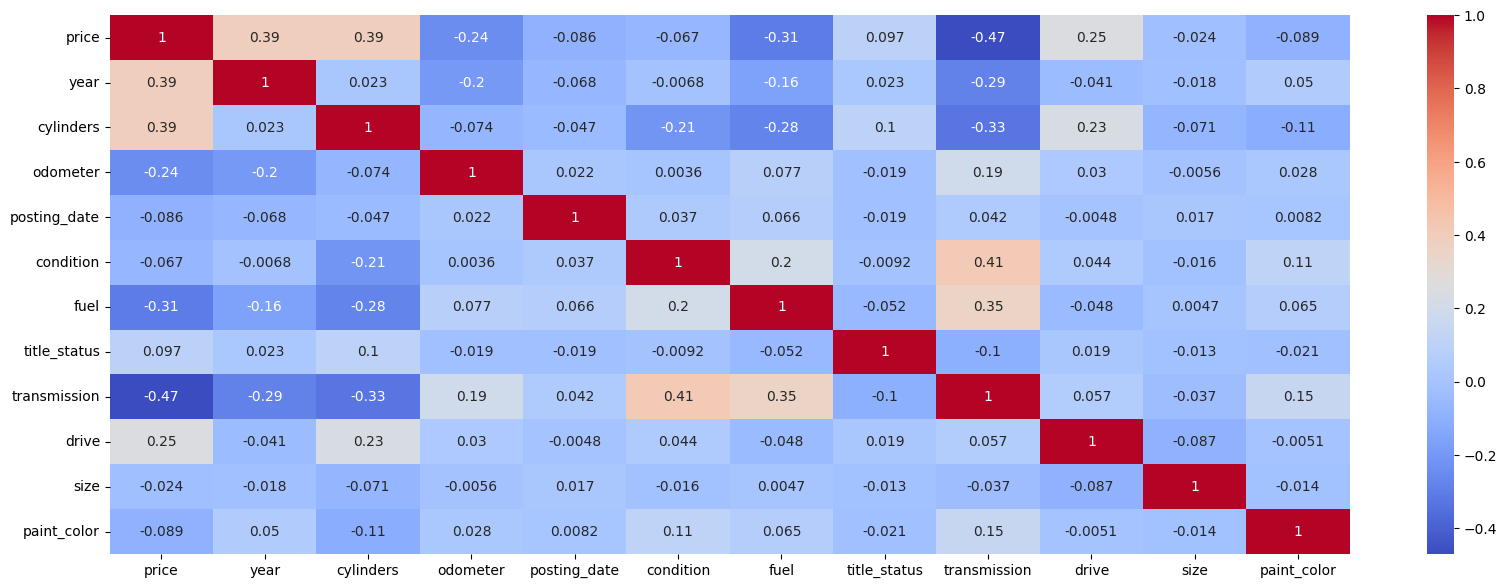

In [121]:
#calculate correlation matris with onehot encoder
corr_matrix_v3 =data_v9.corr()

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(corr_matrix_v3, cmap='coolwarm', annot=True, annot_kws={'size':10}, )
plt.show()

# Dummy model

In [122]:
X = data_v10.drop(columns=['price'])
y = data_v10['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=14564)

In [123]:
dummy_model = LinearRegression()

In [124]:
dummy_model.fit(X_train, y_train)

LinearRegression()

In [125]:
dummy_predict = dummy_model.predict(X_test)

In [126]:
r2_score(dummy_predict,y_test)

0.6320645138775987

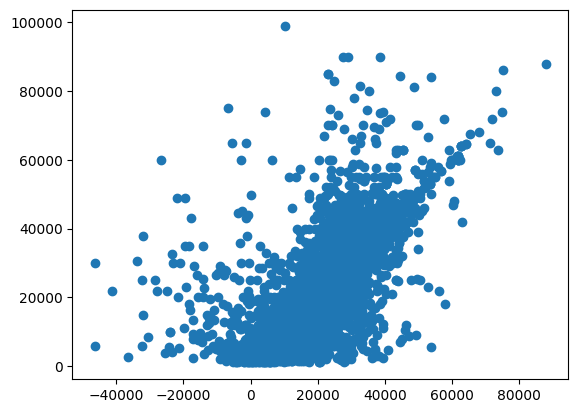

In [127]:
plt.scatter(dummy_predict, y_test)

In [128]:
dummy_errors = y_test - dummy_predict

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 8.000e+00,
        1.500e+01, 6.000e+00, 2.100e+01, 2.300e+01, 1.900e+01, 4.000e+01,
        4.500e+01, 5.900e+01, 9.200e+01, 1.150e+02, 1.330e+02, 2.160e+02,
        3.180e+02, 5.080e+02, 8.080e+02, 1.260e+03, 1.859e+03, 2.917e+03,
        1.363e+03, 7.250e+02, 4.110e+02, 2.850e+02, 1.430e+02, 1.420e+02,
        8.900e+01, 8.400e+01, 5.700e+01, 5.600e+01, 4.600e+01, 4.400e+01,
        3.800e+01, 2.200e+01, 2.200e+01, 1.300e+01, 1.400e+01, 1.300e+01,
        1.300e+01, 1.500e+01, 4.000e+00, 1.100e+01, 5.000e+00, 8.000e+00,
        7.000e+00, 1.000e+01, 3.000e+00, 5.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 3.000e+0

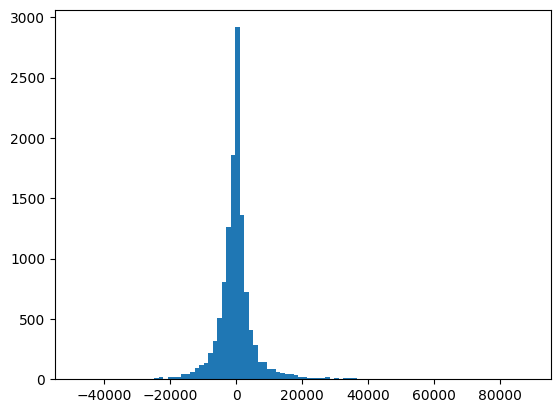

In [129]:
plt.hist(dummy_errors, bins= 100)

In [130]:
rnd_model = RandomForestRegressor()

In [131]:
rnd_model.fit(X_train, y_train)

RandomForestRegressor()

In [132]:
rnd_predict = rnd_model.predict(X_test)

In [133]:
r2_score(rnd_predict,y_test)

0.8946298422768116

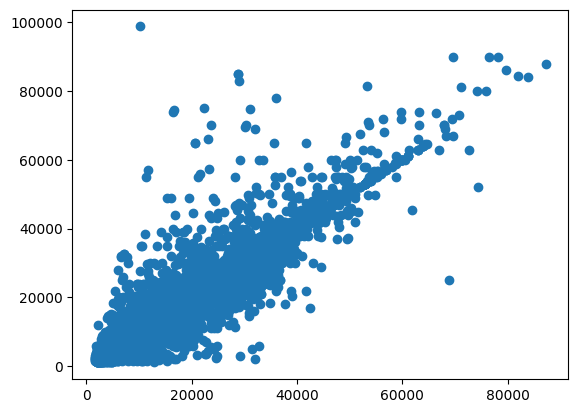

In [134]:
plt.scatter(rnd_predict, y_test)

In [135]:
errors = y_test - rnd_predict

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
        6.000e+00, 6.000e+00, 7.000e+00, 1.700e+01, 1.700e+01, 2.500e+01,
        5.000e+01, 7.400e+01, 9.100e+01, 1.560e+02, 2.460e+02, 5.280e+02,
        1.133e+03, 6.266e+03, 1.752e+03, 6.980e+02, 3.800e+02, 2.140e+02,
        1.410e+02, 7.900e+01, 5.300e+01, 5.300e+01, 3.800e+01, 2.500e+01,
        1.900e+01, 1.800e+01, 1.800e+01, 1.000e+01, 8.000e+00, 7.000e+00,
        6.000e+00, 3.000e+00, 7.000e+00, 8.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

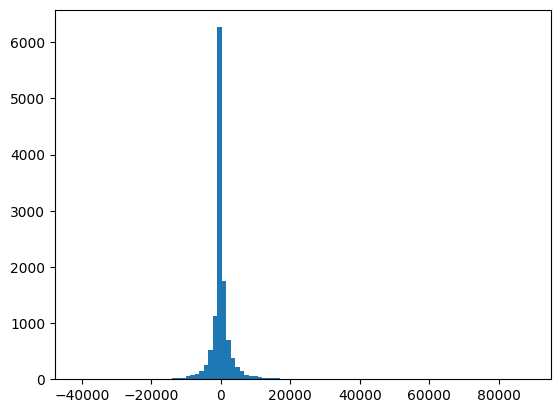

In [ ]:
plt.hist(errors, bins= 100)

saving the models

In [136]:
import pickle
from joblib import dump, load

dump(dummy_model, 'dumm_model.joblib') 
dump(rnd_model, 'rf_model.joblib') 

['rf_model.joblib']

In [137]:
d_model = load('dumm_model.joblib') 
rf_model = load('rf_model.joblib') 

In [138]:
data_v9.to_csv('data_v9.csv', index=False)
data_v10.to_csv('data_v9.csv', index=False)

KeyboardInterrupt: 